# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = '1805_download' # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = 'data' + "/clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length','home_ownership',
                'annual_inc', 'verification_status', 'issue_d', 'loan_status','purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line',
                'open_acc', 'pub_rec','fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
                'last_pymnt_d', 'recoveries'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'installment','annual_inc', 'dti','delinq_2yrs','open_acc', 'pub_rec',
              'fico_range_low','fico_range_high','revol_bal','total_pymnt', 'recoveries']
cat_cols = ['term','grade', 'emp_length','home_ownership','verification_status','loan_status','purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, compression='zip', dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = ~output[i]['id'].map(lambda x: is_integer(x)) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i].loc[~invalid_rows] # remove invalid rows
    
    return output # return dictionary of dataframe

In [7]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory 1805_download/ has 12 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows

### Combine the files

In [8]:
data_cs = pd.concat([x for x in files_cs.values()]) # combine "files_cs" into a pandas dataframe
data_cs.reset_index(drop=True)              # resent index with drop = True

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,NaN,5000,5000,5000,36 months,7.90%,156.46,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,1069639,NaN,7000,7000,7000,60 months,15.96%,170.08,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,1072053,NaN,3000,3000,3000,36 months,18.64%,109.43,E,E1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,1071795,NaN,5600,5600,5600,60 months,21.28%,152.39,F,F2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,1071570,NaN,5375,5375,5350,60 months,12.69%,121.45,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare Final Dataset

In [9]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [10]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


In [11]:
import warnings
warnings.filterwarnings("ignore")

### Typecast the columns

In [12]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

In [13]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc,convert_dtype=True) # apply clean_perc to percentage columns

In [14]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date,convert_dtype=True) # typecast date cloumns to datatime using clean_date

In [15]:
for i in cat_cols:
    final_data[i] = final_data[i].replace('',None, regex=True) # for categorical features if the value is null/empty set it to None
    final_data[i] = final_data[i].replace(np.NaN,None, regex=True)
    final_data[i] = final_data[i].replace(None,None, regex=True)

## Calculate returns for each loan

In [16]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [17]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data.loc[final_data['loan_length']!=0] # select rows where loan_length is not 0. 
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6218 rows


### M1-Pessimistic Method

In [18]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months
final_data['ret_PESS'] = ((12/final_data['term_num'])*(final_data.total_pymnt - final_data.loan_amnt)/(final_data.loan_amnt))*100

### M2-Optimistic Method

In [19]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((12/final_data['loan_length'] )*(final_data.total_pymnt - final_data.loan_amnt)/(final_data.loan_amnt))*100
final_data['ret_OPT'] = np.where(final_data['ret_OPT'] >0, final_data['ret_OPT'], final_data['ret_PESS'])

### Method 3

In [20]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1-((1+i)**final_data.loan_length))/(1-(1+i))) # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = (cash_by_end_of_loan * ((1+i)**(remaining_months))) - final_data.loan_amnt

    # Find the percentage return
    ret_val = ((12/T) * final_return)/(final_data.loan_amnt)*100
    return ret_val

In [21]:
final_data['ret_INTa'] = ret_method_3(60,0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60,0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [22]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        a = final_data.sort_values(i,ascending=False, inplace=False)[i]
        highest_vals = a.unique()[:3]
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [23]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print(final_data[i].nunique()) # print number of distinct values
        print(final_data.groupby(i)['id'].nunique()) # for each distinct value print the number of occurances
        print("")
        print("")

In [24]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

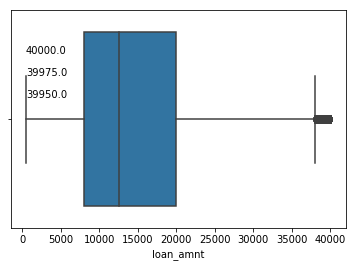

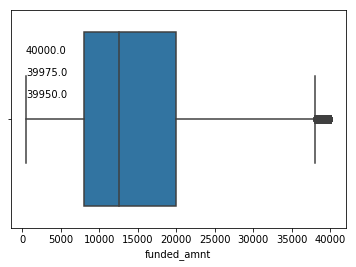

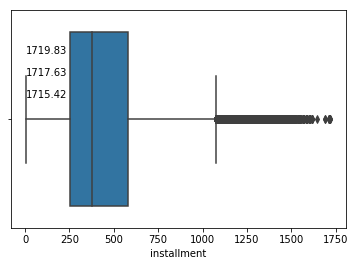

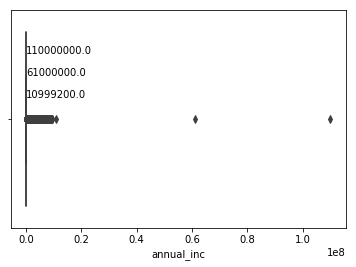

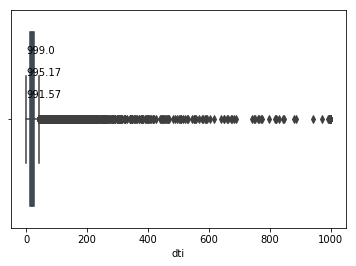

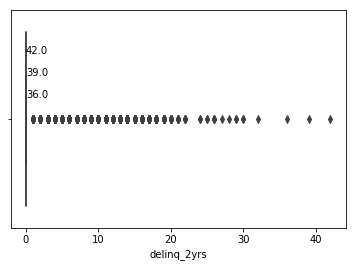

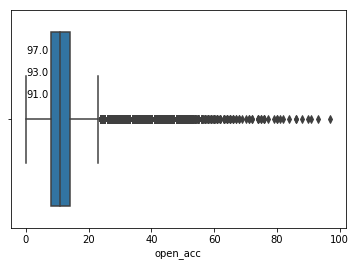

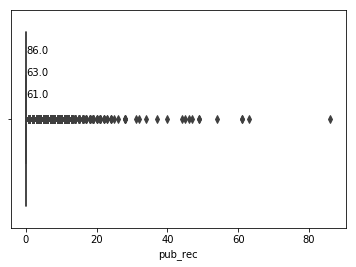

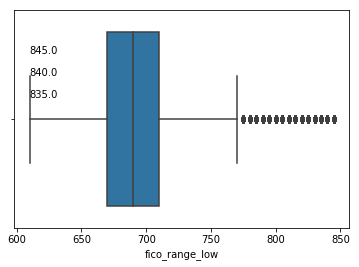

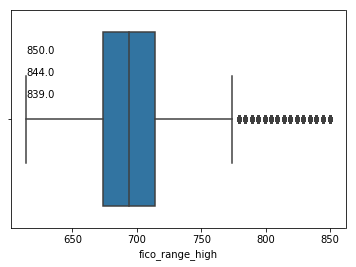

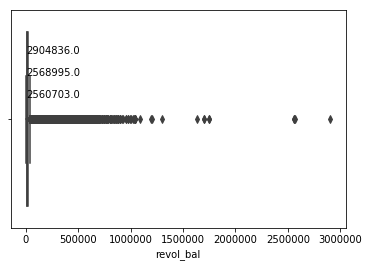

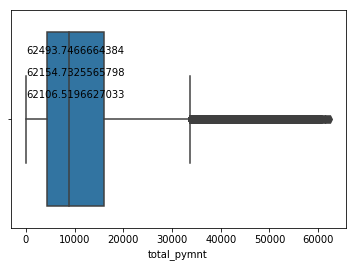

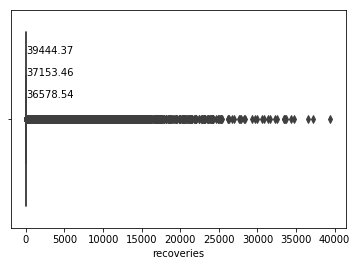

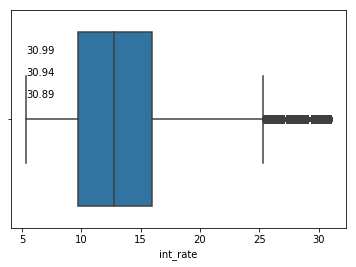

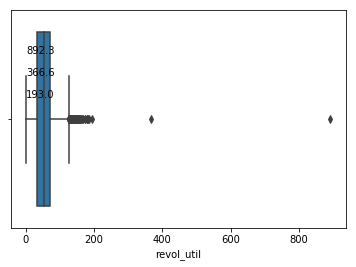

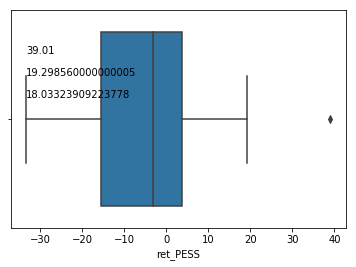

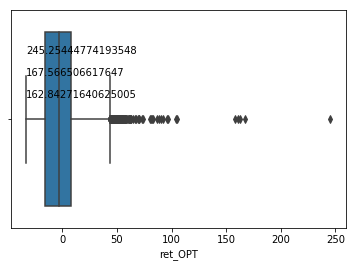

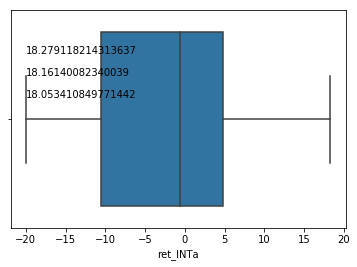

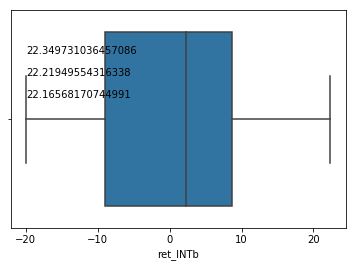

term
2
term
 36 months    1260610
 60 months     498598
Name: id, dtype: int64


grade
7
grade
A    296996
B    520527
C    521315
D    254390
E    116174
F     38424
G     11382
Name: id, dtype: int64


emp_length
11
emp_length
1 year       122173
10+ years    622666
2 years      168379
3 years      148451
4 years      111678
5 years      115152
6 years       85413
7 years       78872
8 years       80388
9 years       70661
< 1 year     155375
Name: id, dtype: int64


home_ownership
6
home_ownership
ANY            504
MORTGAGE    869367
NONE            54
OTHER          182
OWN         191886
RENT        697215
Name: id, dtype: int64


verification_status
3
verification_status
Not Verified       561817
Source Verified    668294
Verified           529097
Name: id, dtype: int64


loan_status
9
loan_status
Charged Off                                            191939
Current                                                792304
Default                                                   39

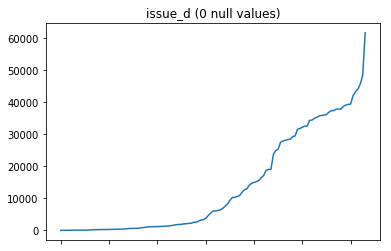

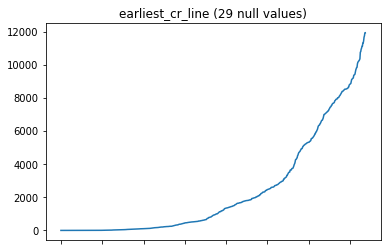

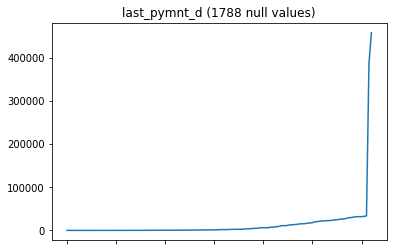

In [25]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

We see a lot fo outliers as is visible in the boxplots above. There are also a lot of null values that need to be removed.

### Handle outliers

In [26]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

def remove_outliers(col):
    Q1 = final_data[col].quantile(0.25)
    Q3 = final_data[col].quantile(0.75)
    IQR = Q3 - Q1
    return final_data.loc[(final_data[col] > Q1-1.5*IQR ) & (final_data[col] < Q3+1.5*IQR)]

final_data = remove_outliers('loan_amnt') # remove outliers based 1st obvious feature
final_data = remove_outliers('funded_amnt')
final_data = remove_outliers('installment')
final_data = remove_outliers('open_acc')
final_data = remove_outliers('fico_range_low')
final_data = remove_outliers('fico_range_high')
final_data = remove_outliers('total_pymnt')
final_data = remove_outliers('int_rate')
final_data = remove_outliers('revol_util')
final_data = remove_outliers('ret_PESS')
final_data = remove_outliers('ret_OPT')

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 285744 rows


We have used the formula of 1.5*Inter quartile range to decide the outliers for the specific columns as a standard practice learned in Statistics. The features that have a lot of outliers and very small inter quartile range haven't been considered because then most of the data will be deleted.

In [27]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data.loc[final_data['loan_status'].str.lower()!='current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 666894 rows


In [28]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data.loc[pd.to_datetime(final_data['issue_d']).dt.year>=2010]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 7379 rows


### Drop null values

In [29]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data = final_data.dropna(axis=0, subset=required_cols) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1348 rows


### Visualize clean data

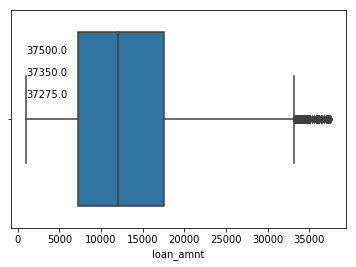

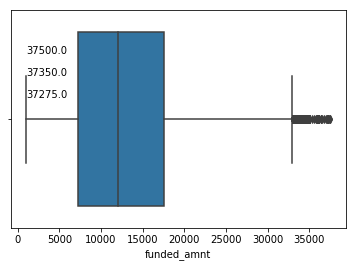

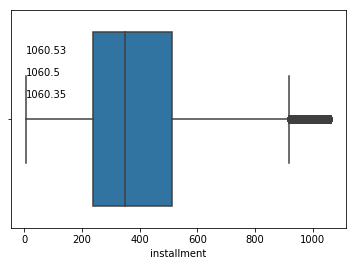

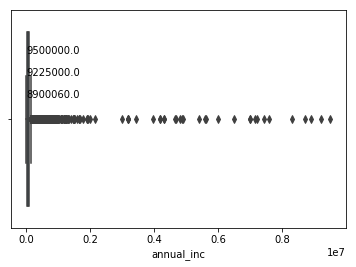

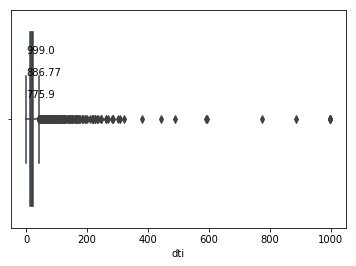

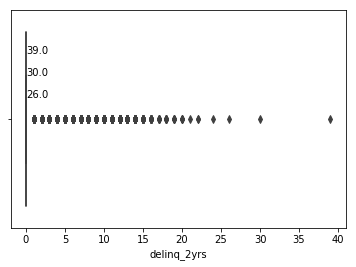

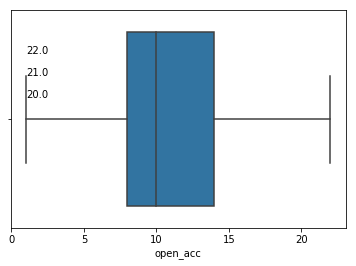

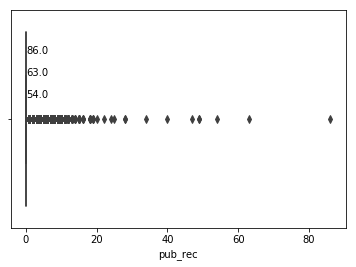

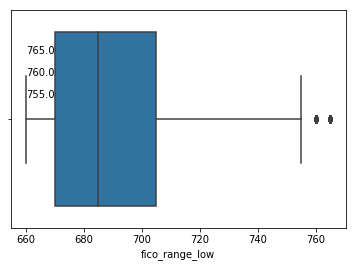

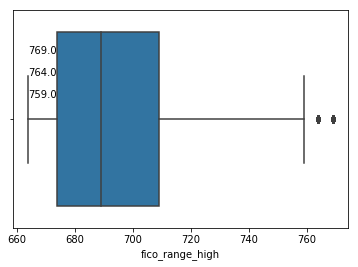

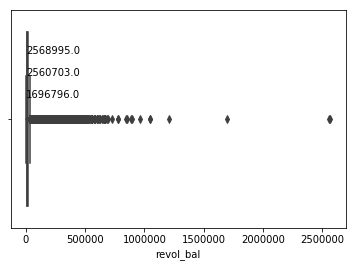

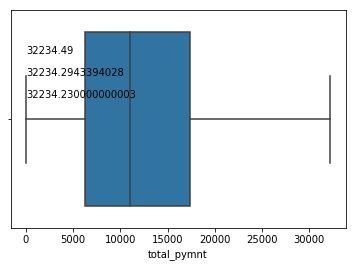

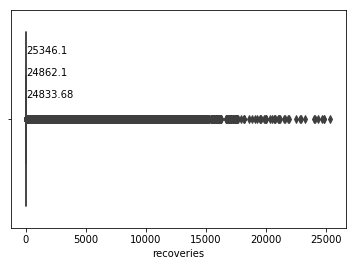

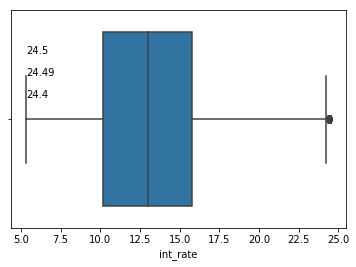

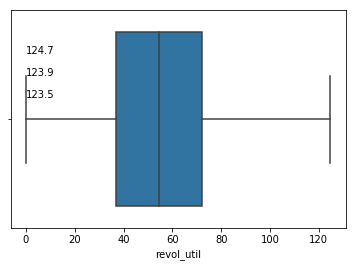

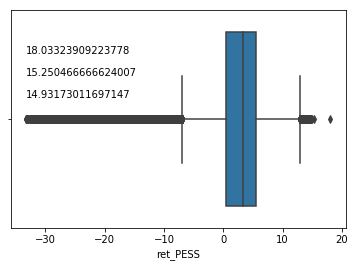

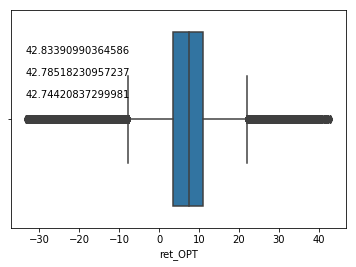

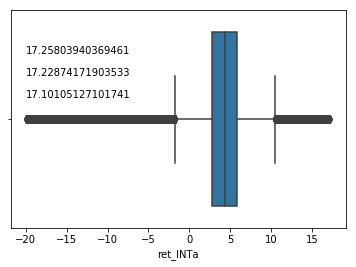

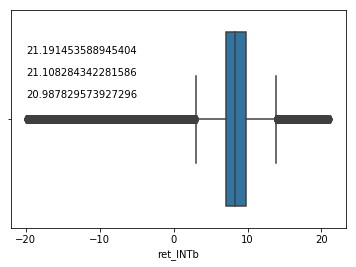

term
2
term
 36 months    625166
 60 months    172677
Name: id, dtype: int64


grade
7
grade
A    122816
B    243803
C    236089
D    126898
E     55255
F     12744
G       238
Name: id, dtype: int64


emp_length
11
emp_length
1 year        56171
10+ years    269148
2 years       77363
3 years       68403
4 years       51181
5 years       53953
6 years       41339
7 years       40014
8 years       39960
9 years       32724
< 1 year      67587
Name: id, dtype: int64


home_ownership
6
home_ownership
ANY            103
MORTGAGE    379823
NONE            35
OTHER           44
OWN          81555
RENT        336283
Name: id, dtype: int64


verification_status
3
verification_status
Not Verified       258562
Source Verified    299818
Verified           239463
Name: id, dtype: int64


loan_status
8
loan_status
Charged Off                                            163568
Default                                                   316
Does not meet the credit policy. Status:Charged Off       255


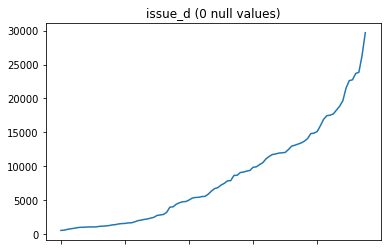

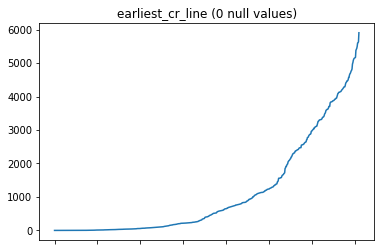

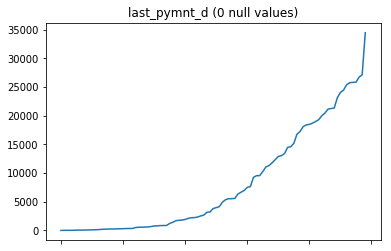

In [30]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

In [31]:
# Visualize the feature correlations
# use sns scatter or pairplot
import seaborn as sns; sns.set(style="ticks")
from sklearn.metrics import confusion_matrix

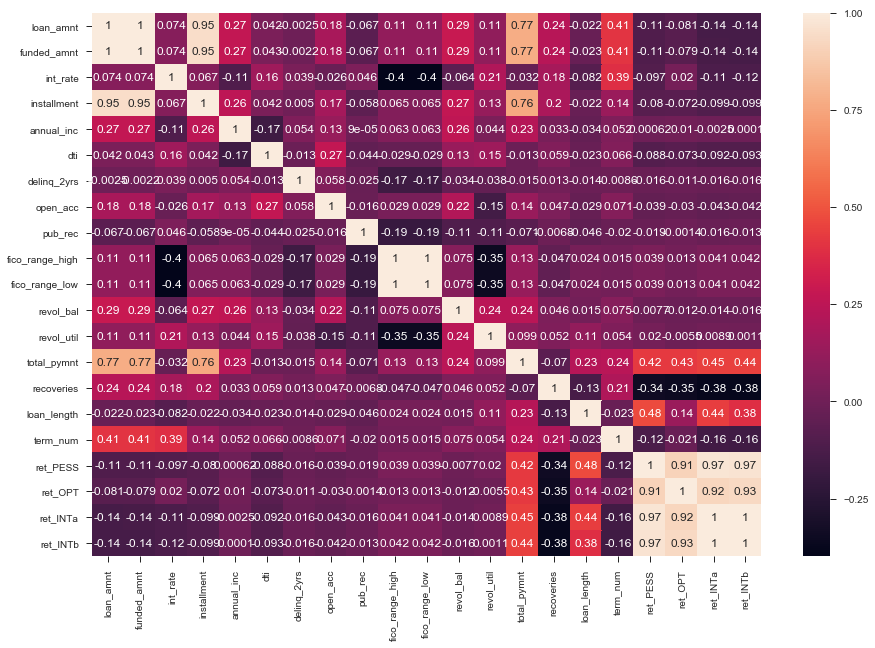

In [32]:
correl = final_data.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(correl, annot=True)
plt.show()

Few results we observe when looking at the correlation matrix are : 
loan_amnt and funded_amnt are highly correlated or possibly duplicate columns. 
Total payment is highly correalted with loan amount, funded amount and installment. 
Interest rate and fico ranges (both low and high) are inversely correlated.
In general, columns and rows having high positive value means they are more positively correlated. Similarly, more negative values means that they are negatively correlated. If the value is close to 0, it means they are very less correlated.

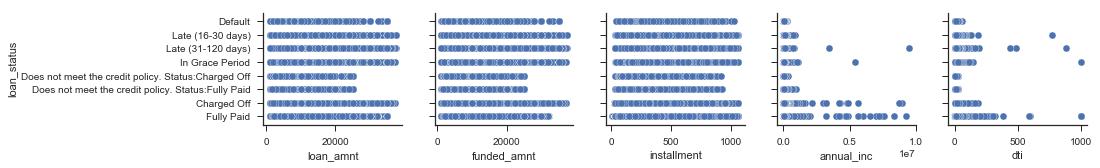

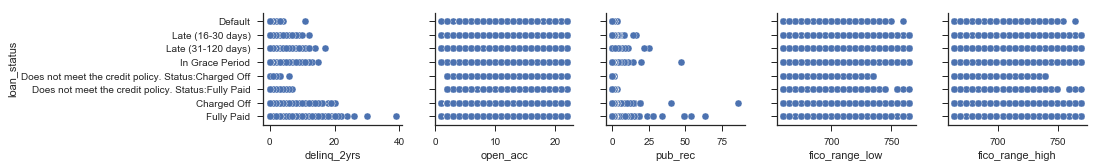

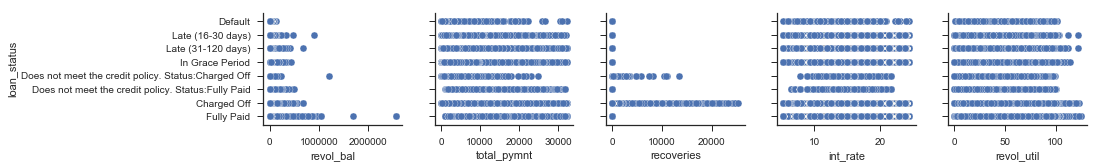

In [33]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations

sns.pairplot(data=final_data, x_vars=continuous_features[:5], y_vars='loan_status')
sns.pairplot(data=final_data, x_vars=continuous_features[5:10], y_vars='loan_status')
sns.pairplot(data=final_data, x_vars=continuous_features[10:], y_vars='loan_status')

We don't see a specific correlation pattern as such from the above scatter plots. But few things we observer are : 
High recoveries is related to charged off loan statues.
High annual income is highly correlated with fully paid loan status. And vice versa, low income will result in defaulting of loans.

What do you observe after removing the outliers?

We observe that the outliers aren't present in most of the features from which we removed them and if they are present, the range of outliers has gone down. 
ret_INTa and ret_INTb did not have any outliers before. But after cleaning the data, these columns got some outliers. Additionaly, the charts for issue_d, earliest_cr_line and last_pymnt_d show better trend post processing since they had a lot of null values before.

### Data Exploration
Solution to Q.7 from the handout

In [34]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade")['ret_OPT'].mean() # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade")['ret_PESS'].mean() # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade")['ret_INTa'].mean() # average return for M3
ret_by_grade_INTb = final_data.groupby("grade")['ret_INTb'].mean() # average return for M3
int_rate_by_grade = final_data.groupby("grade")['int_rate'].mean() # average interest rate for each grade
ret_by_grade_INTc = (ret_by_grade_OPT + ret_by_grade_PESS + ret_by_grade_INTa + ret_by_grade_INTb)/4 # average return

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
combined['return_INTc'] = ret_by_grade_INTc

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb,return_INTc
A,15.393505,8.073052,7.316850,3.573190,1.440495,2.978721,6.564696,3.639276
B,30.557766,16.304968,10.863210,4.394613,1.110325,2.761008,6.340484,3.651608
C,29.590909,27.272342,14.062997,4.259478,-0.208693,1.776737,5.240133,2.766914
D,15.905134,36.229097,17.550174,4.248918,-0.909977,1.088315,4.435807,2.215766
E,6.925548,47.114288,20.403468,3.683668,-1.930937,-0.013365,3.149869,1.222309
F,1.597307,52.856246,23.255448,3.998723,-1.826717,-0.150123,2.955909,1.244448
G,0.029830,55.042017,21.447479,3.228755,-0.426342,1.343376,4.326949,2.118185


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [35]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = list(set(continuous_features) - set(['total_pymnt','recoveries']))

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

This is mainly because we will train our model to test on the loans as if they are prospective future investment or not. But the test data would not contain these two features. So, we would not have access to these two features and hence, these variables cannot be used for deciding which loan to invest in. Moreover, these features are also correlated with other features. So keeping them would mean increasing the effect of these features on the outcome variable.

In [36]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )